## This code is for demonstration of using regression model (in my case Ordinary Least Square (OLS) model from statsmodels library) along with Backward Elimination Technique.

### Content

* *[Heatmap without dummy variables](#heatmap_nodummy)*

* *[Heatmap with Dummy Variables](#heatmap_withdummy)*

* *[Function for Automatic Backward Elimination](#elimination_code)*

* *[Simple Linear Regression using OLS](#OLS_regressor)*

* *[Residual Graph without Backward Elimination](#residual_graph)*

* *[Function for calculating RMS Error](#rms_function)*

* *[Original v/s Predicted values graph](#origvspred_graph)*

* *[Residual Scatter Plot](#residual_plot)*

* *[Conclusion of Model (without using Backward Elimination) ](#conclusion)*

* *[Conclusion of Model (after using Backward Elimination) ](#conclusion_be)*

* *[Summary](#summary)*

In [43]:
import os
print(os.listdir("../input"))

['diamonds.csv']


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
odf = pd.read_csv('../input/diamonds.csv')

In [3]:
odf.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
# Dropping first column of dataframe
odf.drop(columns=odf.columns[0], axis = 1, inplace=True)
odf.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [5]:
odf.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
# Categorizing columns according to data types
categorical = odf.columns[[1,2,3]]
to_predict = 'price'
numeric = odf.columns[[0,4,5,6,7,8,9]]

In [7]:
# Checking for missing values in dataset
for c in odf.columns:
    print('Total Missing values in \'{}\' are {}.'.format(c,odf[c].isna().sum()))

Total Missing values in 'carat' are 0.
Total Missing values in 'cut' are 0.
Total Missing values in 'color' are 0.
Total Missing values in 'clarity' are 0.
Total Missing values in 'depth' are 0.
Total Missing values in 'table' are 0.
Total Missing values in 'price' are 0.
Total Missing values in 'x' are 0.
Total Missing values in 'y' are 0.
Total Missing values in 'z' are 0.


In [8]:
# Replacing zero values of x, y and z with NaNs. After then NaN will be dropped

odf[['x','y','z']] = odf[['x','y','z']].replace(0,np.NaN)

odf.dropna(inplace=True)

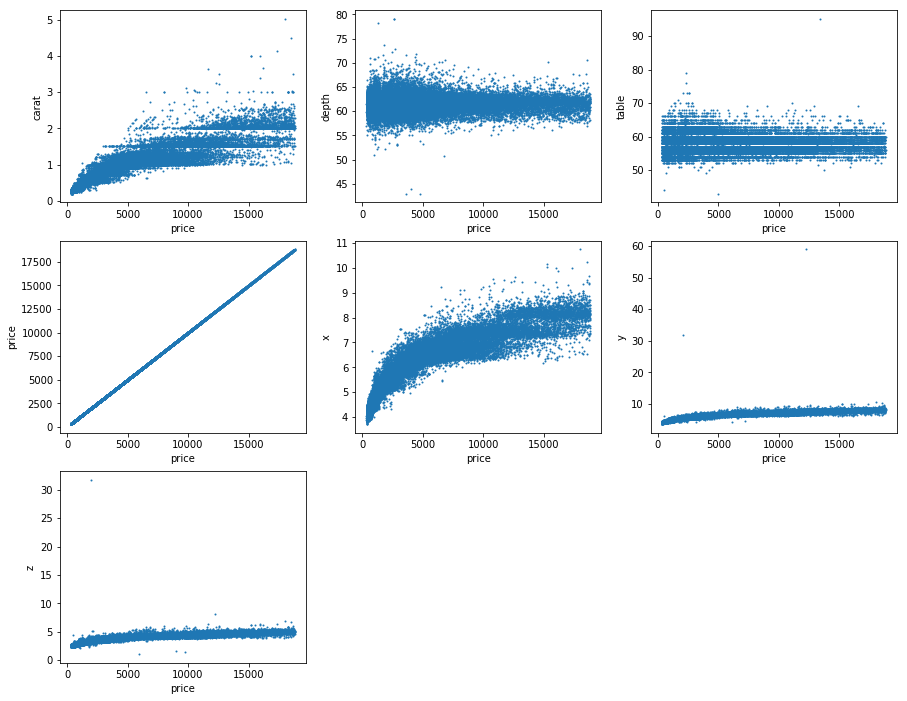

In [9]:
plt.figure(figsize=(15,12))
for i in range(1,8):
    plt.subplot(3, 3, i)
    plt.scatter(odf['price'], odf[numeric[i-1]], s= 1)
    plt.xlabel(to_predict)
    plt.ylabel(numeric[i-1])

* From above figure, It looks like 'y' and 'z' have some outliers. Dropping them might increase the accuracy.

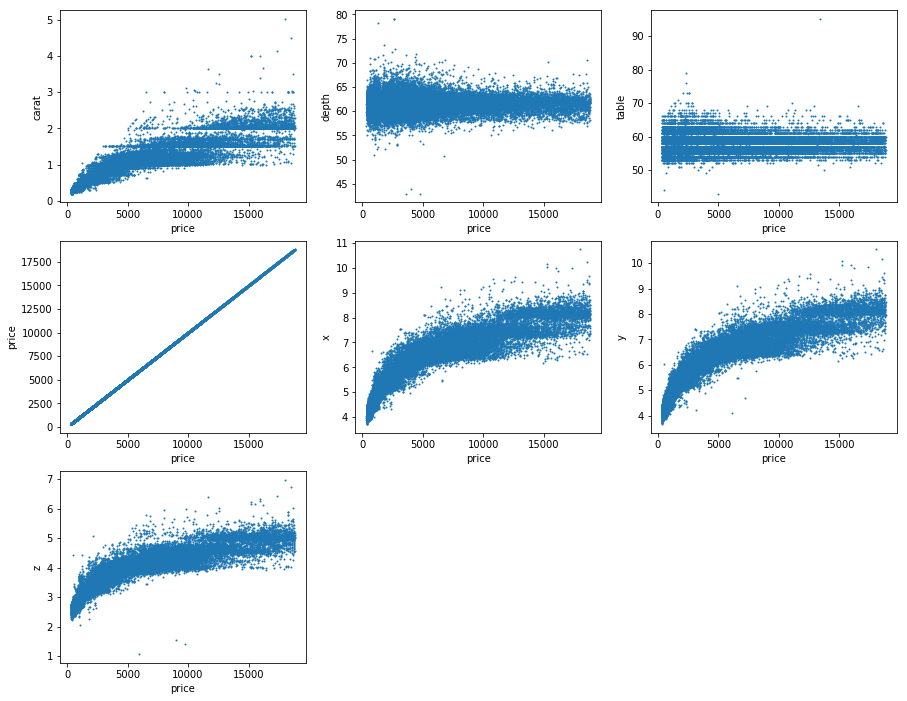

In [10]:
odf.drop(odf[odf.y > 20].index, inplace=True) # Dropping outliers from 'y' column
odf.drop(odf[odf.z > 20].index, inplace=True) # Dropping outliers from 'z' column

plt.figure(figsize=(15,12))
for i in range(1,8):
    plt.subplot(3, 3, i)
    plt.scatter(odf['price'], odf[numeric[i-1]], s= 1)
    plt.xlabel(to_predict)
    plt.ylabel(numeric[i-1])

### From figures above it seems like few independent variables or features don't have linear relationship with the dependent variable.

<a id='heatmap_nodummy'></a>
##  Heatmap without dummy variables

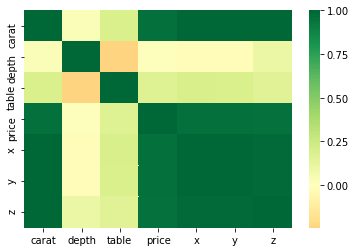

In [11]:
p = sns.heatmap(odf.corr('spearman'), center=0, cmap = 'RdYlGn')

### Heatmap above shows a strong correlation between various independent (as assumed) variables.

In [12]:
# Making dummy variables for categorical Columns
odfd = pd.get_dummies(data=odf, columns=categorical)

In [13]:
# Dropping Extra caegoricals
lst = ['color_D','cut_Fair','clarity_IF']
idx = []
for i in lst:
    # Removing D color from color column, Fair cut and IF clarity column
    idx.append(odfd.columns.get_loc(i))
    
odfd.drop(columns=odfd.columns[idx], axis = 1, inplace=True)

In [14]:
# Rearranging columns of dataframe

col = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E', 
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2', 'price']

odfd = odfd[col]

<a id='heatmap_withdummy'></a>
## Heatmap with Dummy Variables

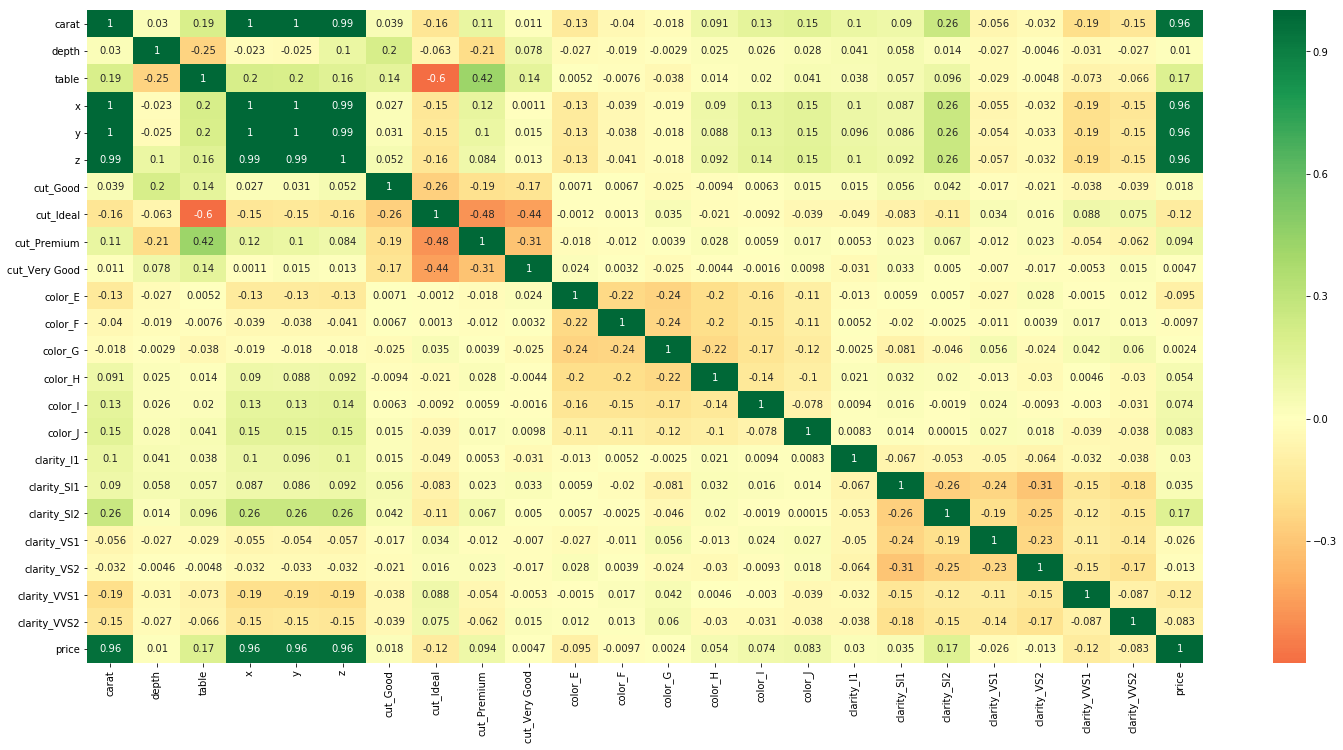

In [15]:
plt.figure(figsize=(25,12))
p = sns.heatmap(data=odfd.corr(method='spearman'), annot=True, cmap='RdYlGn', center=0)

* From above figure it can be seen that carat is highly correlated to x, y, x and vice-versa. Apart from that, dependent variable is also highly corelated to these four variables.

<a id='elimination_code'></a>
## Function for Automatic Backward Elimination

In [16]:
# Automating backward elimination technique

def DoBackwardElimination(the_regressor, X, y, minP2eliminate):
    
    assert np.shape(X)[0] == np.shape(y)[0], 'Length of X and y do not match'
    assert minP2eliminate > 0, 'Minimum P value to eliminate cannot be zero or negative'
    
    original_list = list(range(0, np.shape(the_regressor.pvalues)[0]))
    
    max_p = 10        # Initializing with random value of maximum P value
    i = 0
    r2adjusted = []   # Will store R Square adjusted value for each loop
    r2 = []           # Will store R Square value  for each loop
    list_of_originallist = [] # Will store modified index of X at each loop
    classifiers_list = [] # fitted classifiers at each loop
    
    while max_p >= minP2eliminate:
        
        p_values = list(the_regressor.pvalues)
        r2adjusted.append(the_regressor.rsquared_adj)
        r2.append(the_regressor.rsquared)
        list_of_originallist.append(original_list)
        
        max_p = max(p_values)
        max_p_idx = p_values.index(max_p)
        
        if max_p_idx == 0:
            
            temp_p = set(p_values)
            
            # removing the largest element from temp list
            temp_p.remove(max(temp_p))
            
            max_p = max(temp_p)
            max_p_idx = p_values.index(max_p)
            
            print('Index value 0 found!! Next index value is {}'.format(max_p_idx))
            
            if max_p < minP2eliminate:
                
                print('Max P value found less than 0.1 with 0 index ...Loop Ends!!')
                
                break
                
        if max_p < minP2eliminate:
            
            print('Max P value found less than 0.1 without 0 index...Loop Ends!!')
            
            break
        
        val_at_idx = original_list[max_p_idx]
        
        idx_in_org_lst = original_list.index(val_at_idx)
        
        original_list.remove(val_at_idx)
        
        print('Popped column index out of original array is {} with P-Value {}'.format(val_at_idx, np.round(np.array(p_values)[max_p_idx], decimals= 4)))
        
        X_new = X[:, original_list]
        
        the_regressor = smf.OLS(endog = y, exog = X_new).fit()
        classifiers_list.append(the_regressor)
        
        print('==================================================================================================')
        
    return classifiers_list, r2, r2adjusted, list_of_originallist

<a id='OLS_regressor'></a>
## Simple Linear Regression using OLS

In [17]:
# Preprocessing data

X = odfd.iloc[:,:-1].values          # Selecting all columns except last one that is 'price'.
y = odfd['price'].values

# # Adding constant values at start of array X
# X = np.append(arr = np.ones((X.shape[0], 1)).astype(int), values=X, axis=1)

In [18]:
# Scaling input data

from sklearn.preprocessing import MinMaxScaler

mscalar = MinMaxScaler()

X_minmax_scaled = mscalar.fit_transform(X)

In [19]:
# Adding constant values at start of array X
X_minmax_scaled = np.append(arr = np.ones((X_minmax_scaled.shape[0], 1)).astype(int), values=X_minmax_scaled, axis=1)

In [20]:
X_lst = list(range(0, X.shape[1]))
X_opt = X_minmax_scaled[:,X_lst]
flag = 2 # Done intentionally in order to stop popping 5th column from input array X

In [21]:
# To be used when doing manual elimination
# Eliminating columns according to P values from summary to make new X_opt
idx_to_pop = 5
if flag == 1:
    X_lst.pop(element_to_pop)
    flag = 99
    
X_opt = X_minmax_scaled[:,X_lst]

In [22]:
# Splitting data for taining and testing
X_train, X_test, y_train, y_test = train_test_split(X_opt, y, test_size=0.25, random_state=22)

In [23]:
# Fitting the regressor
regressor_SLR_OLS = smf.OLS(endog = y_train, exog = X_train).fit()

# Looking at the summary of regressor
print(regressor_SLR_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 2.136e+04
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:18:12   Log-Likelihood:            -3.4116e+05
No. Observations:               40437   AIC:                         6.824e+05
Df Residuals:                   40414   BIC:                         6.826e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2240.0516    140.288     15.968      0.0

<a id='residual_graph'></a>
## Residual Graph without using Backward Elimination

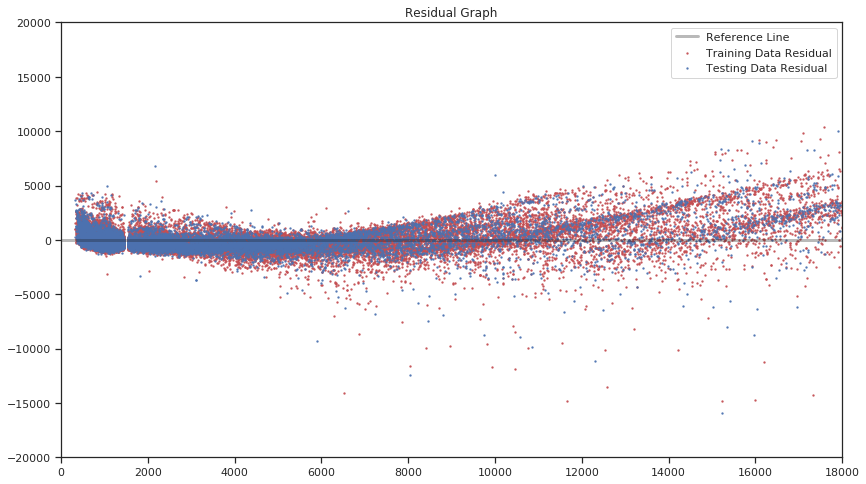

In [44]:
sns.set(style='ticks')
plt.figure(figsize=(14,8))
y_pred_train = regressor_SLR_OLS.predict(X_train)
y_pred_test = regressor_SLR_OLS.predict(X_test)

plt.scatter(y_train, y_train-y_pred_train, s= 2, c= 'R', alpha=0.8)
plt.scatter(y_test, y_test-y_pred_test, s= 2, c= 'B', alpha=0.8)
plt.plot([0, 18000], [0,0], '-k', linewidth = 3, alpha = 0.3)
p = plt.xlim((0, 18000))
p = plt.ylim((-20000, 20000))
p = plt.legend(['Reference Line','Training Data Residual', 'Testing Data Residual'])
p = plt.title('Residual Graph')

<a id='rms_function'></a>
## Function for calculating RMS Error

In [25]:
def Calculate_Error(original_values, predicted_values):
    assert len(original_values) == len(predicted_values), 'Both list should have same length'
    temp = 0
    error = 0
    n = len(original_values)
    for o, p in zip(original_values, predicted_values):
        temp = temp + ((o-p)**2)
        
    temp = temp/n
    error = np.sqrt(temp)
    return error
        

In [26]:
train_data_error = Calculate_Error(original_values=y_train, predicted_values=y_pred_train)
test_data_error = Calculate_Error(original_values=y_test, predicted_values=y_pred_test)

print('MSE for training data is {}'.format(np.round(train_data_error, 4)))
print('MSE for testing data is {}'.format(np.round(test_data_error, 4)))

MSE for training data is 1116.4907
MSE for testing data is 1153.1703


<a id='origvspred_graph'></a>
## Original v/s Predicted values graph 

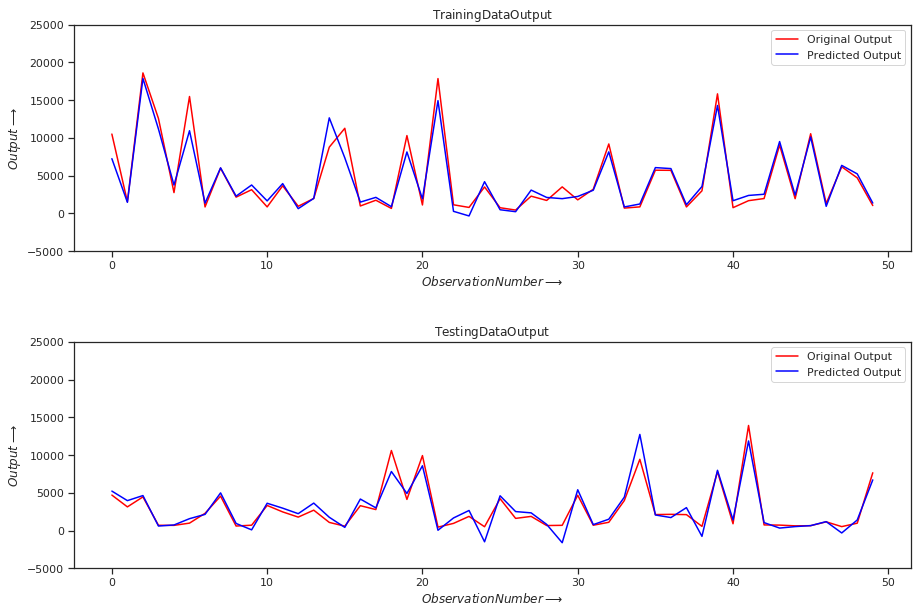

In [27]:
random.seed(22)
plt.figure(figsize=(15, 10))
rand_nums1 = random.sample(range(0, len(y_train)), 50)
plt.subplot(2,1,1)
# plt.figure(figsize=(15,10))
p = plt.plot(range(0, 50), y_train[rand_nums1, ], color = 'red')
p = plt.plot(range(0, 50), y_pred_train[rand_nums1, ], color = 'blue')
plt.title(r'$ \mathrm{\mathsf{Training Data Output}}$')
plt.legend(['Original Output', 'Predicted Output'])
plt.xlabel(r'$Observation  Number \longrightarrow$')
plt.ylabel(r'$Output \longrightarrow$')
plt.ylim(-5000, 25000)


rand_nums2 = random.sample(range(0, len(y_test)), 50)
plt.subplot(2,1,2)
p = plt.plot(range(0, 50), y_test[rand_nums2, ], color = 'red')
p = plt.plot(range(0, 50), y_pred_test[rand_nums2, ], color = 'blue')
plt.title(r'$ \mathrm{\mathsf{Testing Data Output}}$')
plt.legend(['Original Output', 'Predicted Output'])
plt.xlabel(r'$Observation  Number \longrightarrow$')
plt.ylabel(r'$Output \longrightarrow$')
plt.ylim(-5000, 25000)

plt.subplots_adjust(hspace=0.4)

In [28]:
training_residual = []
for o, p in zip(y_train[rand_nums1, ], y_pred_train[rand_nums1, ]):
    training_residual.append(o-p)
    
testing_residual = []
for o, p in zip(y_test[rand_nums2, ], y_pred_test[rand_nums2, ]):
    testing_residual.append(o-p)

<a id='residual_plot'></a>
## Residual Scatter Plot

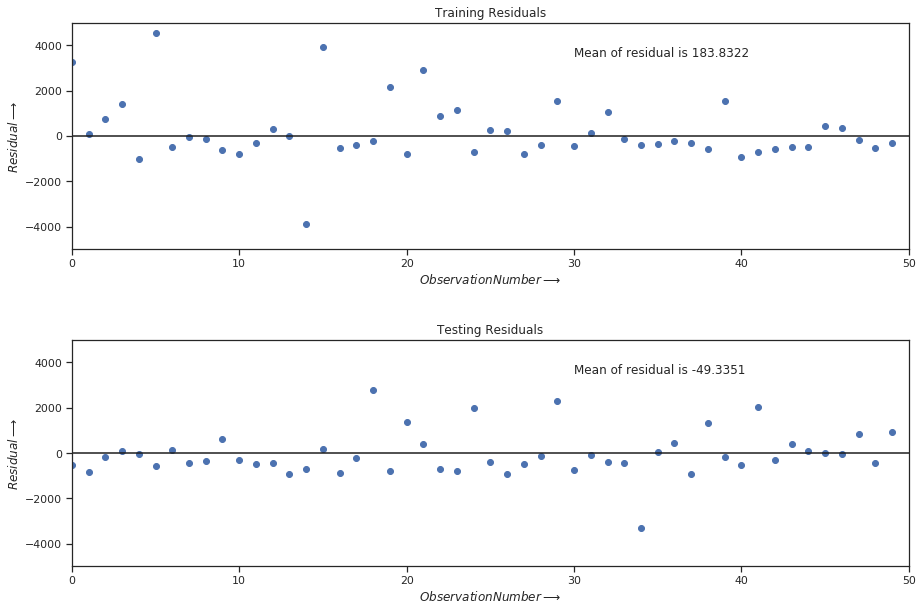

In [29]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
# p = plt.bar(list(range(0, 50)),training_residual, align='center', width = 1, fill= False, edgecolor = 'k')
p = plt.scatter(list(range(0, 50)),training_residual)
p = plt.plot([0, 50], [0, 0], '-k')
plt.text(30,3500, 'Mean of residual is {}'.format(np.round(np.mean(training_residual), 4)))
plt.ylim(-5000, 5000)
plt.xlim(0,50)
plt.title('Training Residuals')
plt.xlabel(r'$Observation  Number \longrightarrow$')
plt.ylabel(r'$Residual \longrightarrow$')


plt.subplot(2,1,2)
# p = plt.bar(list(range(0, 50)),testing_residual, align='center', width = 1, fill= False, edgecolor = 'k')
p = plt.scatter(list(range(0, 50)),testing_residual)
p = plt.plot([0, 50], [0, 0], '-k')
plt.text(30,3500, 'Mean of residual is {}'.format(np.round(np.mean(testing_residual), 4)))
plt.ylim(-5000, 5000)
plt.xlim(0,50)
plt.title('Testing Residuals')
plt.xlabel(r'$Observation  Number \longrightarrow$')
plt.ylabel(r'$Residual \longrightarrow$')

plt.subplots_adjust(hspace= 0.4)

In [30]:
print('Mean of \'price\' for training data is {}.'.format(np.round(np.mean(y_train),4)))
print('Mean of residual of \'price\' for training data is {}.'.format(np.round(np.mean(training_residual),4)))

print('Mean of \'price\' for testing data is {}.'.format(np.round(np.mean(y_test),4)))
print('Mean of residual of \'price\' for training data is {}.'.format(np.round(np.mean(testing_residual),4)))

Mean of 'price' for training data is 3916.1771.
Mean of residual of 'price' for training data is 183.8322.
Mean of 'price' for testing data is 3975.1074.
Mean of residual of 'price' for training data is -49.3351.


<a id='conclusion'></a>
### Following things can be concluded regarding model on the bases of above values:
* Mean of residual for training data is 183.83 which is about 4.7% of mean diamond price in training data.
* Same is with the residual for testing data set. It's residual is about 1.24% of mean diamond price in same set.
* Also, mean price of diamonds in both training and testing dataset is almost equal thus not causing any bias in residual.

In [31]:
# Now it's time to do backward elimination and check wether it improves performance of our regression model

regressor_list, r2, r2adjusted, list_of_changes = DoBackwardElimination(the_regressor=regressor_SLR_OLS, 
                                                                        X= X_train, y= y_train, minP2eliminate = 0.05)

Popped column index out of original array is 22 with P-Value 0.1928
Max P value found less than 0.1 without 0 index...Loop Ends!!


In [40]:
new_list = list_of_changes[1]
new_regressor = regressor_list[0]
print(new_regressor.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 2.237e+04
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:29:23   Log-Likelihood:            -3.4116e+05
No. Observations:               40437   AIC:                         6.824e+05
Df Residuals:                   40415   BIC:                         6.826e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2227.8536    139.976     15.916      0.0

In [37]:
y_pred_train_new = new_regressor.predict(X_train[:, new_list])
y_pred_test_new = new_regressor.predict(X_test[:, new_list])

training_residual_new = []
for o, p in zip(y_train[rand_nums1, ], y_pred_train_new[rand_nums1, ]):
    training_residual_new.append(o-p)
    
testing_residual_new = []
for o, p in zip(y_test[rand_nums2, ], y_pred_test_new[rand_nums2, ]):
    testing_residual_new.append(o-p)

In [41]:
print('Mean of \'price\' for training data is {}.'.format(np.round(np.mean(y_train),4)))
print('Mean of residual of \'price\' for training data is {}.'.format(np.round(np.mean(training_residual_new),4)))

print('Mean of \'price\' for testing data is {}.'.format(np.round(np.mean(y_test),4)))
print('Mean of residual of \'price\' for training data is {}.'.format(np.round(np.mean(testing_residual_new),4)))

Mean of 'price' for training data is 3916.1771.
Mean of residual of 'price' for training data is 184.8154.
Mean of 'price' for testing data is 3975.1074.
Mean of residual of 'price' for training data is -50.7096.


<a id='conclusion_be'></a>
* From above values of residual means, it is evident that eliminating a feature actually not improving the model efficiency rather decreasing it's performance.
* For both training and testing data mean residual increased by 0.02% and 0.04% respectively, which is not a very big value but still not what we crave for.

<a id='summary'></a>
## SUMMARY:
**The best model for this dataset is 'regressor_SLR_OLS' with R Square and Adjusted R Square of 0.921**

## In order to increase efficiency of this model, we will go for other techniques like polynomial fitting in next notebook.